# Visualize the molecules

In [1]:
run_directory = 'results/definitive_chembl/'

## Results including single runs

In [2]:
import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

from plot_utils import *
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import copy
import re 

params = {
    'font.size': 18,
    'legend.fontsize': 18,
    'text.usetex': False,
}
rcParams.update(params)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
sub = ['(Cl)', '(OC)', '(Cl)', '(N(C)C)', '(O)', '(N)', '(C)', '([N+](=O)[O-])', '(C#N)', '(C(C)=O)', '(C(N)=O)', '(S(N)(=O)=O)', '(S(C)(=O)=O)', '(C(C)(C)C)', '(C(F)(F)F)', '(Br)', '(I)']

def topliss_walk(smiles, n_combinations=2):
    mols = [smiles]
    for step in range(n_combinations):
        new_mols = []
        for mol in mols: 
            positions = [m.start() for m in re.finditer('c', mol)]
            for p in positions:
                for s in sub:
                    if Chem.MolFromSmiles(mol[:p] + s + mol[p:]):
                        new_mols.append(mol[:p] + s + mol[p:])
        mols.extend(new_mols)
    return mols

def one_ecfp(smile, radius=2):
    "Calculate ECFP fingerprint. If smiles is invalid return none"
    try:
        m = Chem.MolFromSmiles(smile)
        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(
            m, radius, nBits=1024))
        return fp
    except:
        return None
    
def ecfp(smiles):
    """Input: list of SMILES
       Output: list of descriptors.
       Compute ECFP4 featurization."""
    X = [one_ecfp(s, radius=2) for s in smiles]
    return X

In [4]:
def compute_tolerance_intervals(trajectory, scores_1, scores_2, steps=[0, 31, 61, 91, 121, 150], n_samples=10):
    #print(trajectory)
    n_runs = trajectory.shape[0]
    n_steps = trajectory.shape[1]
    n_molecules = len(trajectory[0, 0])

    alternative_predictions = copy.deepcopy(trajectory)
    tolerance_intervals = []
    for step in steps:
        ti = []
        for run in range(n_runs):
            for molecule in range(len(trajectory[run, step])):
                if trajectory[run, step][molecule]:
                    index = np.argmin(np.abs(np.array(scores_1)-trajectory[run, step][molecule]))
                    ti.append(np.random.choice(a=scores_2[index]))
        tolerance_intervals.append(ti)    
    return tolerance_intervals, steps


def optimization_vs_control_even_ranges(scores_1, scores_2, min_samples = 25):
    score_max, score_min = max(scores_1), min(scores_1)
    #score_min = 0
    #score_max = 1.0
    counts = []
    n_steps = 10
    step = (score_max - score_min)/n_steps
    control_scores = []
    optimization_scores = []
    control_spread = []
    scores_1 = np.array(scores_1)
    scores_2 = np.array(scores_2)
    lower_bound = 0
    upper_bound = step
    while upper_bound<score_max:
        #lower_bound = i*step
        #upper_bound = (i+1)*step
        indexes_low = np.where(scores_1>=lower_bound)[0]
        indexes_up = np.where(scores_1<upper_bound)[0]
        indexes_step = []
        for j in range(len(scores_1)):
            if j in indexes_low and j in indexes_up:
                indexes_step.append(j)
        indexes_step = np.array(indexes_step)           
        counts.append(len(indexes_step))
        if len(indexes_step)> min_samples:
            control_scores.append(np.mean(scores_2[indexes_step]))
            optimization_scores.append((upper_bound + lower_bound) / 2)
            control_spread.append(scores_2[indexes_step])
       
            lower_bound += step
            upper_bound += step
        else:
            upper_bound += step
                
    return control_spread, control_scores, optimization_scores


def fit_clfs(df, is_aldh1=False, topliss_augmented=False, data_control=True):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints

    
    if is_aldh1:
        df = pd.read_csv("210415_LIT_PCBA_ALDH1_Best_AB_sets.csv")
        in_set_A = np.where(df['in_set_A']==1)[0]
        in_set_B = np.where(df['in_set_B']==1)[0]
        smiles = df["SMILES"]
        activity = df["Act"]
        index_test = []
        for i in range(len(smiles)):
            if i not in in_set_A and i not in in_set_B:
                index_test.append(i)

        in_test = np.array(index_test)

        #in_test = np.where(df['in_set_A']==0 and df['in_set_B']==0)


        X1 = np.array(ecfp(smiles[in_set_A]))
        X2 = np.array(ecfp(smiles[in_set_B]))

        y1 = np.array(activity[in_set_A])
        y2 = np.array(activity[in_set_B])
        smiles_test = np.array(smiles)[in_test]
    else:
        df['ecfp'] = ecfp(df.smiles)
        df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=0)


        df1, df2 = train_test_split(df_train, test_size=0.5, stratify=df_train['label'], random_state=0)
        X1 = np.array(list(df1['ecfp']))
        X2 = np.array(list(df2['ecfp']))

        y1 = np.array(list(df1['label']))
        y2 = np.array(list(df2['label']))

        del df1['ecfp']
        del df2['ecfp']
        smiles_test = df_test.smiles
    
    
    balance = (np.mean(y1), np.mean(y2))
    clf_1 = RandomForestClassifier(
        n_estimators=100, random_state=0)
    clf_1_alt = RandomForestClassifier(
        n_estimators=100, random_state=1)

    clf_2 = RandomForestClassifier(
        n_estimators=100, random_state=0)
    clf_1.fit(X1, y1)
    clf_1_alt.fit(X1, y1)
    clf_2.fit(X2, y2)
    test_scores = clf_1.predict_proba(ecfp(smiles_test))[:, 1]
    
    if topliss_augmented:
        augmented_smiles_test = []
        for i, s in enumerate(smiles_test):
            if test_scores[i]>0.25:
                augmented_smiles_test.extend(topliss_walk(s, n_combinations=2))
            else:
                augmented_smiles_test.extend([s])
        augmented_smiles_test = np.array(augmented_smiles_test)
        X_test = ecfp(augmented_smiles_test)
    else:
        X_test = ecfp(smiles_test)

    scores_1 = clf_1.predict_proba(X_test)[:, 1]
    if data_control:
        scores_2 = clf_2.predict_proba(X_test)[:, 1]
    else:
        scores_2 = clf_1_alt.predict_proba(X_test)[:, 1]

    return scores_1, scores_2

In [5]:
def load_chid(chid_dir, order, **kwargs):
    runs = [run for run in os.listdir(chid_dir) if os.path.isfile(chid_dir / run / 'results.json')]
    accumulate = []
    for run in runs:
        run_dir = chid_dir / run
        with open(run_dir / 'results.json', 'r') as f:
            results = json.load(f)

        # some runs aborted earlier. Solve this by adding the last entry a few times!
        # TODO: solve this in a better way.
        n_gen = len(results['statistics'])

        if n_gen != 151:
            results['statistics'] += [results['statistics'][-1]] * \
                (151 - n_gen)

        # create a dictionary containing arrays of shape [n_iter, n_molecules]
        preds_internal = flatten([row['preds']
                                  for row in results['statistics']])
        smiles = [row['smiles'] for row in results['statistics']]
        # array for each clf and split
        preds_external = results['predictions_external']
        accumulate.append((preds_internal, preds_external,
                           results['AUC'], smiles, ))

    # preds_internal, preds_external, aucs = [flatten(x) for x in list(zip(*accumulate))]
    preds_internal, preds_external, aucs, smiles, = list(
        zip(*accumulate))
    preds_internal = flatten(preds_internal)
    preds_external = flatten(preds_external)
    aucs = flatten(aucs)
    # legacy compatibility
    for d in [preds_internal, preds_external, aucs]:
        if 'all' in d:
            del d['all']
    preds_internal, preds_external, aucs = [
        {k: d[k] for k in order} for d in [preds_internal, preds_external, aucs]]
    return preds_internal, preds_external, aucs, smiles

def get_chid_values(chid):
    assay_file = 'assays/processed/' + chid + '.csv'
    print('Reading data from: {assay_file}')
    df = pd.read_csv(assay_file)

    df['ecfp'] = ecfp(df.smiles)
    df1, df2 = train_test_split(df, test_size=0.5, stratify=df['label'], random_state=1)

    X1 = np.array(list(df1['ecfp']))
    X2 = np.array(list(df2['ecfp']))

    y1 = np.array(list(df1['label']))
    y2 = np.array(list(df2['label']))

    del df1['ecfp']
    del df2['ecfp']

    balance = (np.mean(y1), np.mean(y2))

    # train classifiers and store them in dictionary
    clf = RandomForestClassifier(
        n_estimators=100, random_state=0)
    clf.fit(X1, y1)
    scores = clf.predict_proba(X2)[:, 1][np.where(y2==1)]
    scores_inactive = clf.predict_proba(X1)[np.where(y1==0)]
    #scores = scores_inactive
    return np.mean(scores), np.percentile(scores,5), np.percentile(scores, 95), np.median(scores_inactive), np.percentile(scores_inactive,25), np.percentile(scores_inactive, 75)

def median_score_compound(pred, color=None, label=None, shade=False, alpha=.1, **kwargs):
    # pred is triply nested list [n_runs, n_epochs, n_mol(variable_size) ]
    # get mean scores over runs
    pred_mean = np.array([[np.mean([z for z in y if z is not None]) for y in x] for x in pred]).T
    median = np.median(pred_mean, 1)
    q25 = np.percentile(pred_mean, 25, axis=1)
    q75 = np.percentile(pred_mean, 75, axis=1)

    plt.plot(median, c=color, label=label, **kwargs)

    plt.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=alpha, color=color)
    
def median_score_single(pred, color=None, label=None, alpha=.1, **kwargs):
    medians = np.array([[np.median([t for t in y if t is not None]) for y in x] for x in pred])
    q25 = np.array([[np.percentile([t for t in y if t is not None], 25) for y in x] for x in pred])
    q75 = np.array([[np.percentile([t for t in y if t is not None], 75) for y in x] for x in pred])
    n_runs = medians.shape[0]
    for i in range(n_runs):
        plt.plot(medians[i], c=color, label=label, **kwargs)
        label = None  # avoid multiple legend entries
        plt.fill_between(
            np.arange(medians[i].shape[0]), q25[i], q75[i], alpha=alpha, color=color)

def plot_wrapper(preds_internal, primitive, name, col_dict, legend_dict, ls_dict, alpha_dict, skip=[], xlabel=None, ylabel=None, ax=None, legend=True, leg_lw=3, **kwargs):
    if ax is not None:
        plt.sca(ax)
    for k, pred in preds_internal.items():
        if k in skip:
            continue
        primitive(
            pred, color=col_dict[k], label=legend_dict[k], ls=ls_dict[k], alpha=alpha_dict[k], **kwargs)

    if legend:
        leg = plt.legend(loc='upper center', bbox_to_anchor=(
            0.5, 1.14), ncol=3, frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(leg_lw)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [6]:
results_dir = Path(run_directory)
figure_dir = Path('figures')
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

write = False
columns = ['AssayID', 'TargetName', 'TargetID']
rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217'),
        ('CHEMBL1794345', 'Pla. Fal.', 'CHEMBL364'),
        ('CHEMBL1741322', 'Cytochrome', 'CHEMBL3356'),
        ('CHEMBL1963961', 'CCRF-CEM', 'CHEMBL382')]
assay_info = pd.DataFrame(rows, columns=columns)
# display(assay_info)

# dictionary to convert chemblID to readable name
chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))

# The predictions for OS, MCS and DCS are saved in dictionaries with these keys
# These dictionaries map these identifiers to more readable strings, colors/linestyles used in plots
order = ('Split1', 'Split1_alt', 'Split2')
legend_dict = dict(zip(order, ['Optimization score', 'Model control score', 'Data control score']))
opt_dict = {'graph_ga': 'GA', 'lstm_hc': 'LSTM', 'mso': 'PS'}
col_dict = dict(zip(order, ['blue', 'green', 'red']))
col_dict2 = dict(zip(order, ['cyan', 'magenta', 'green']))
ls_dict = dict(zip(order, ['-', '--', '-.']))

# get chembl identifiers used in experiments
# go one step down in tree to get the name of some optimizer ('graph_ga' or 'lstm_hc')
chids = sorted(os.listdir(run_directory + 'graph_ga'))

columns = ['AssayID', 'TargetName', 'TargetID']
rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217'),
        ('CHEMBL1794345', 'Pla. Fal.', 'CHEMBL364'),
        ('CHEMBL1741322', 'Cytochrome', 'CHEMBL3356'),
        ('CHEMBL1963961', 'CCRF-CEM', 'CHEMBL382')]
assay_info = pd.DataFrame(rows, columns=columns)
# display(assay_info)

# dictionary to convert chemblID to readable name
chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))

# The predictions for OS, MCS and DCS are saved in dictionaries with these keys
# These dictionaries map these identifiers to more readable strings, colors/linestyles used in plots
order = ('Split1', 'Split1_alt', 'Split2')
legend_dict = dict(zip(order, ['Optimization score', 'Model control score', 'Data control score']))
opt_dict = {'graph_ga': 'GA', 'lstm_hc': 'LSTM', 'mso': 'PS'}
col_dict = dict(zip(order, ['blue', 'green', 'red']))
col_dict2 = dict(zip(order, ['cyan', 'magenta', 'green']))
ls_dict = dict(zip(order, ['-', '--', '-.']))

# get chembl identifiers used in experiments
# go one step down in tree to get the name of some optimizer ('graph_ga' or 'lstm_hc')
chids = sorted(os.listdir(run_directory + 'graph_ga'))
# get some stats on these assays


# get mean and std of all the classifiers trained for dataset
optimizers = sorted([o.name for o in results_dir.iterdir() if o.is_dir()])

# Single runs analysis

graph_ga
lstm_hc
mso


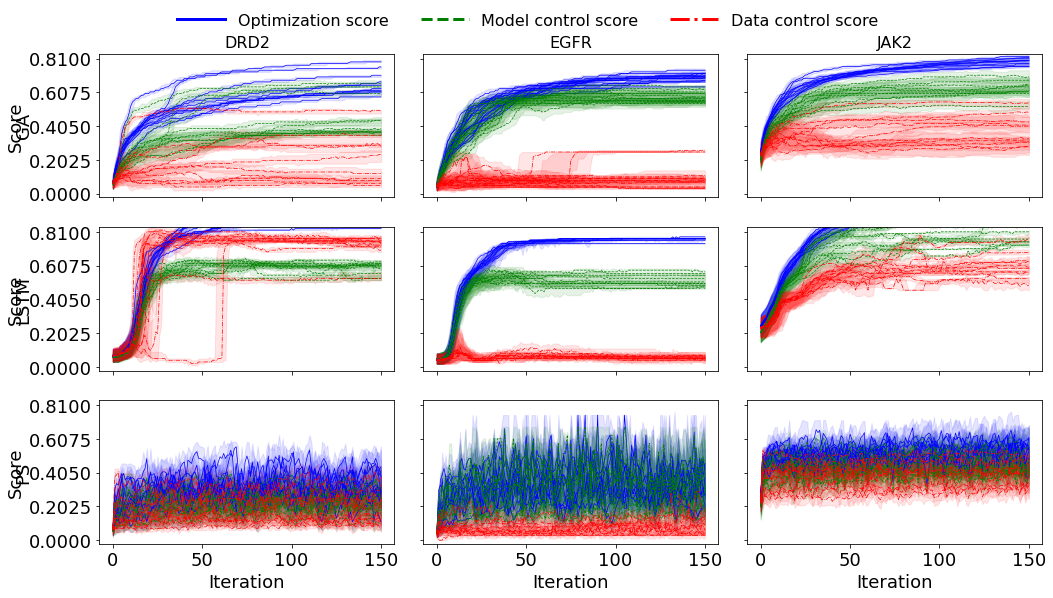

In [7]:
#chids = ['CHEMBL3888429', 'CHEMBL3888429']
#title_dict = ['ALDH1', 'JAK2 cleaned']
#optimizers = ['graph_ga', 'lstm_hc', 'mso']
auc_title = False # whether or not to include auc in plot
lw = 0.7 # line width
nrows = 3 # for two optimizers
ncols = len(chids) # for the number of tasks


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 2.75*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    print(optimizer)
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        preds_internal, preds_external, auc, _, = load_chid(
            results_dir/optimizer/chid, order)
        
        plot_wrapper(preds_internal, median_score_single, name='median_score_single', col_dict=col_dict, legend_dict=legend_dict, ls_dict=ls_dict, alpha_dict = dict(zip(order, [0.1, 0.1, 0.1])), ax=ax, legend=False, lw=lw)
        
        # makes ticks a bit prettier and always makes them at multiples of 0.2
        low, high = ax.set_ylim()
        #yticks = np.arange(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 0.2)
        yticks = np.linspace(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 5)
        ax.set_yticks(yticks)

# set axes labels 
for i in range(nrows):
    axes[i][0].set_ylabel('Score')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Iteration')

# set titles to denote tasks
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    #title += f' ({aucs[chid][0]:.2f})'
    axes[0][i].set_title(title, fontsize=16)

# create legend
custom_lines = [Line2D([0], [0], color=col_dict[k], lw=3, ls=ls_dict[k]) for k in col_dict.keys()]
lgd = fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16,handlelength=3)

# add optimizer info by adding text
text_fields = []
xtext = -55
for i, optimizer in enumerate(optimizers):
    txt = axes[i][0].text(xtext, sum(axes[i][0].get_ylim()) /2 , opt_dict[optimizer], rotation=90, verticalalignment='center')
    text_fields.append(txt)
    
fig.tight_layout()

if write or True:
    plt.savefig('median_scores_trajectories.pdf', bbox_extra_artists=[lgd]+text_fields, bbox_inches='tight')

# Averaged runs analysis

graph_ga
lstm_hc
mso


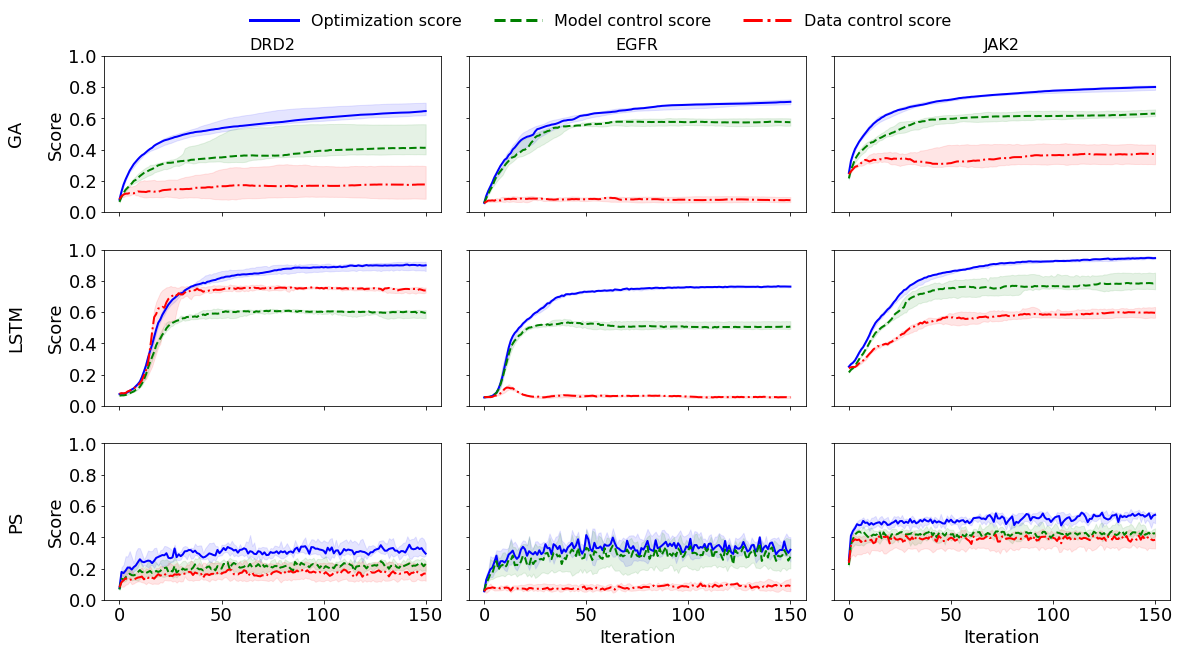

In [8]:
auc_title = False # whether or not to include auc in plot
lw = 2 # line width
nrows = 3 # for two optimizers
ncols = len(chids) # for the number of tasks


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.5*ncols, 3*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    print(optimizer)
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        preds_internal, preds_external, auc, _, = load_chid(
            results_dir/optimizer/chid, order)
        
        plot_wrapper(preds_internal, median_score_compound, name='median_score_compound', col_dict=col_dict, alpha_dict = dict(zip(order, [0.1, 0.1, 0.1])), legend_dict=legend_dict, ls_dict=ls_dict, ax=ax, legend=False, lw=lw)
        
        # makes ticks a bit prettier and always makes them at multiples of 0.2
        #ax.set_ylim(0, 1)
        ax.set_ylim(0, 1)
        low, high = 0, 1
        step = (high-low)/5
        yticks = np.arange(round(low/step) * step, round(high/step) * step +0.01, step)
        #yticks = np.linspace(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 5)

        ax.set_yticks(yticks)

# set axes labels 
for i in range(nrows):
    axes[i][0].set_ylabel('Score')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Iteration')

# set titles to denote tasks
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    if auc_title:
        title += f' ({aucs[chid][0]:.2f})'
    axes[0][i].set_title(title, fontsize=16)

# create legend
custom_lines = [Line2D([0], [0], color=col_dict[k], lw=3, ls=ls_dict[k]) for k in col_dict.keys()]
lgd = fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16,handlelength=3)

# add optimizer info by adding text
text_fields = []
xtext = -55
for i, optimizer in enumerate(optimizers):
    txt = axes[i][0].text(xtext, sum(axes[i][0].get_ylim()) /2 , opt_dict[optimizer], rotation=90, verticalalignment='center')
    text_fields.append(txt)
    
fig.tight_layout()
plt.savefig('figures/median_scores_new_datasets_start_from_chembl.pdf', bbox_inches='tight')
